In [50]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [48]:
# Load the processed data
adata = sc.read_h5ad("/Users/aumchampaneri/Databases/Triple/Human_Nor-CKD-AKF_scRNA_processed.h5ad")

# Load the gene dictionary from the csv file
gene_dict = {}
with open('complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]

# Find all the cell types in the data
cell_types = adata.obs['cell_type'].unique()
for cell_type in cell_types:
    print(cell_type)

kidney collecting duct principal cell
kidney interstitial cell
kidney loop of Henle thin descending limb epithelial cell
endothelial cell
epithelial cell of proximal tubule
kidney loop of Henle thick ascending limb epithelial cell
kidney loop of Henle thin ascending limb epithelial cell
kidney collecting duct intercalated cell
cytotoxic T cell
non-classical monocyte
conventional dendritic cell
T cell
kidney interstitial alternatively activated macrophage
mature NK T cell
plasma cell
mononuclear phagocyte
monocyte
B cell
natural killer cell
plasmacytoid dendritic cell, human
mast cell
kidney distal convoluted tubule epithelial cell
podocyte
parietal epithelial cell
kidney connecting tubule epithelial cell


In [12]:
adata

AnnData object with n_obs × n_vars = 225151 × 29893
    obs: 'orig.ident', 'nCount_RNA', 'SpecimenID', 'LibraryID', 'SampleID', 'Run', 'clusterNumber', 'subclass.l1', 'dataSource', 'diseasetype', 'Race', 'clusterClass', 'organism_ontology_term_id', 'assay_ontology_term_id', 'sampletype', 'disease_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'Age_binned', 'cell_type_ontology_term_id', 'author_cell_type', 'diabetes_history', 'hypertension', 'eGFR', 'is_primary_data', 'disease_category', 'nFeature_RNA', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'index', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'def

/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_4602/807202224.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


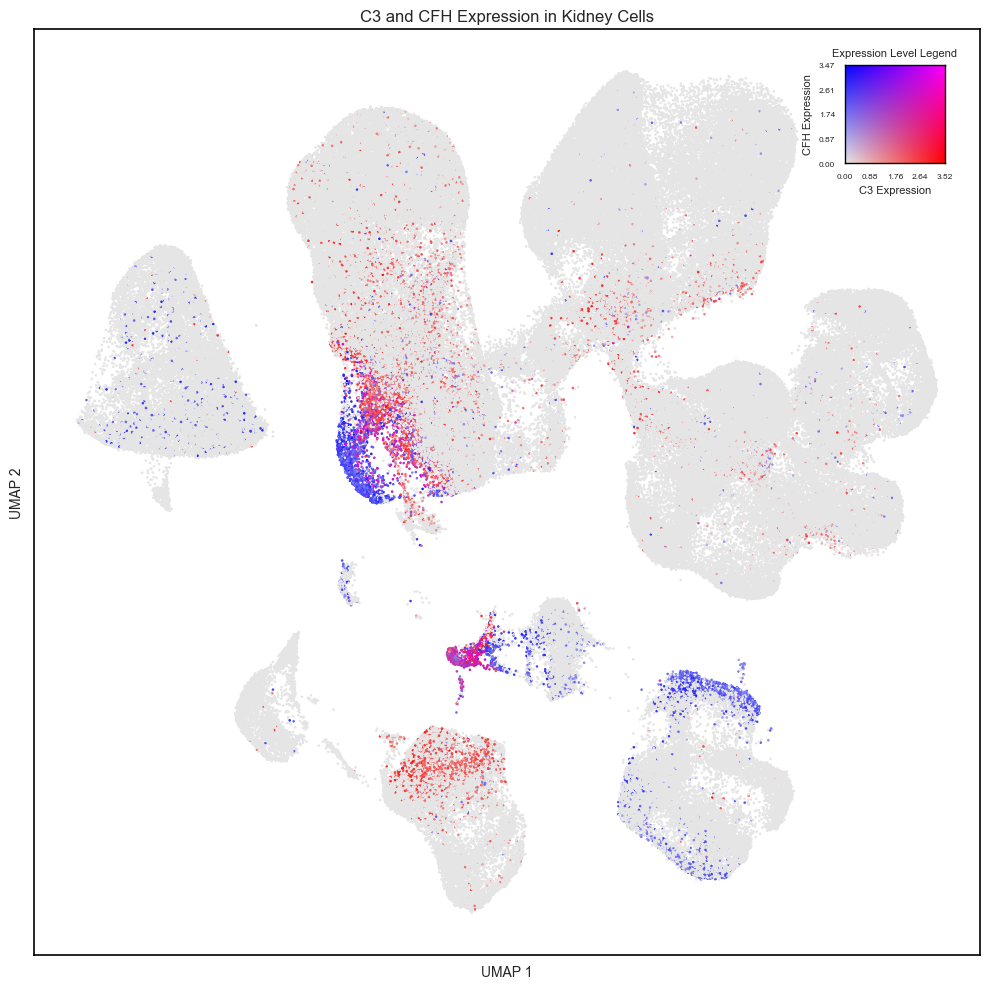

In [51]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

# Define gene keys for C3 and CFH
c3_key = "ENSG00000125730"  # C3
cfh_key = "ENSG00000000971"  # CFH


def get_expression(key):
    exp = adata[:, key].X
    return exp.toarray().flatten() if scipy.sparse.issparse(exp) else exp.flatten()


# Extract expression data
c3_vals = get_expression(c3_key)
cfh_vals = get_expression(cfh_key)

# Determine the data range for each gene
c3_min, c3_max = c3_vals.min(), c3_vals.max()
cfh_min, cfh_max = cfh_vals.min(), cfh_vals.max()

# Generate five evenly spaced tick values
c3_ticks = np.linspace(c3_min, c3_max, 5)
cfh_ticks = np.linspace(cfh_min, cfh_max, 5)

# Rescale the raw data to [0,1] for color mapping
X_scatter = (c3_vals - c3_min) / (c3_max - c3_min)
Y_scatter = (cfh_vals - cfh_min) / (cfh_max - cfh_min)

# Define the white basis as light grey
white_val = 0.9

# Compute weight factors
w = (1 - X_scatter) * (1 - Y_scatter)
r = X_scatter * (1 - Y_scatter)
b = (1 - X_scatter) * Y_scatter
p = X_scatter * Y_scatter

# Compute scatter plot colors
scatter_R = white_val * w + 1 * r + 0 * b + 1 * p
scatter_G = white_val * w + 0 * r + 0 * b + 0 * p
scatter_B = white_val * w + 0 * r + 1 * b + 1 * p

scatter_colors = np.column_stack([scatter_R, scatter_G, scatter_B])
scatter_colors = np.clip(scatter_colors, 0, 1)

# Create figure and axes
fig = plt.figure(figsize=(10, 10), facecolor='white')
ax_umap = fig.add_subplot(111)
ax_legend = fig.add_axes([0.85, 0.83, 0.10, 0.10])
ax_umap.set_facecolor('white')

# Plot UMAP scatter
ax_umap.scatter(
    adata.obsm['X_umap'][:, 0],
    adata.obsm['X_umap'][:, 1],
    c=scatter_colors,
    s=0.75,
    alpha=1.0
)

ax_umap.set_title('C3 and CFH Expression in Kidney Cells')
ax_umap.set_xlabel('UMAP 1')
ax_umap.set_ylabel('UMAP 2')
ax_umap.grid(False)
ax_umap.tick_params(axis='both', which='both', length=0)
ax_umap.set_xticklabels([])
ax_umap.set_yticklabels([])

for spine in ax_umap.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.2)

# ---- Build the legend colormap ----
n_bins = 100
x_lin = np.linspace(c3_min, c3_max, n_bins)
y_lin = np.linspace(cfh_min, cfh_max, n_bins)
X_leg, Y_leg = np.meshgrid(x_lin, y_lin)

# Rescale legend meshgrid values to [0,1]
X_leg_scaled = (X_leg - c3_min) / (c3_max - c3_min)
Y_leg_scaled = (Y_leg - cfh_min) / (cfh_max - cfh_min)

# Compute weight factors for the legend
w_leg = (1 - X_leg_scaled) * (1 - Y_leg_scaled)
r_leg = X_leg_scaled * (1 - Y_leg_scaled)
b_leg = (1 - X_leg_scaled) * Y_leg_scaled
p_leg = X_leg_scaled * Y_leg_scaled

# Compute legend color mapping
legend_R = white_val * w_leg + 1 * r_leg + 0 * b_leg + 1 * p_leg
legend_G = white_val * w_leg + 0 * r_leg + 0 * b_leg + 0 * p_leg
legend_B = white_val * w_leg + 0 * r_leg + 1 * b_leg + 1 * p_leg

legend_color = np.stack([legend_R, legend_G, legend_B], axis=2)
legend_color = np.clip(legend_color, 0, 1)

ax_legend.imshow(legend_color, origin='lower', extent=[c3_min, c3_max, cfh_min, cfh_max])
ax_legend.set_xlabel('C3 Expression', fontsize=8)
ax_legend.set_ylabel('CFH Expression', fontsize=8)
ax_legend.set_title('Expression Level Legend', fontsize=8)
ax_legend.grid(False)

# Apply the new tick values
ax_legend.set_xticks(c3_ticks)
ax_legend.set_yticks(cfh_ticks)
ax_legend.set_xticklabels([f"{val:.2f}" for val in c3_ticks], fontsize=6)
ax_legend.set_yticklabels([f"{val:.2f}" for val in cfh_ticks], fontsize=6)

for spine in ax_legend.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tight_layout()
# plt.savefig('umap_C3vCFH_nor1.pdf')
plt.show()

/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_4602/3512045363.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


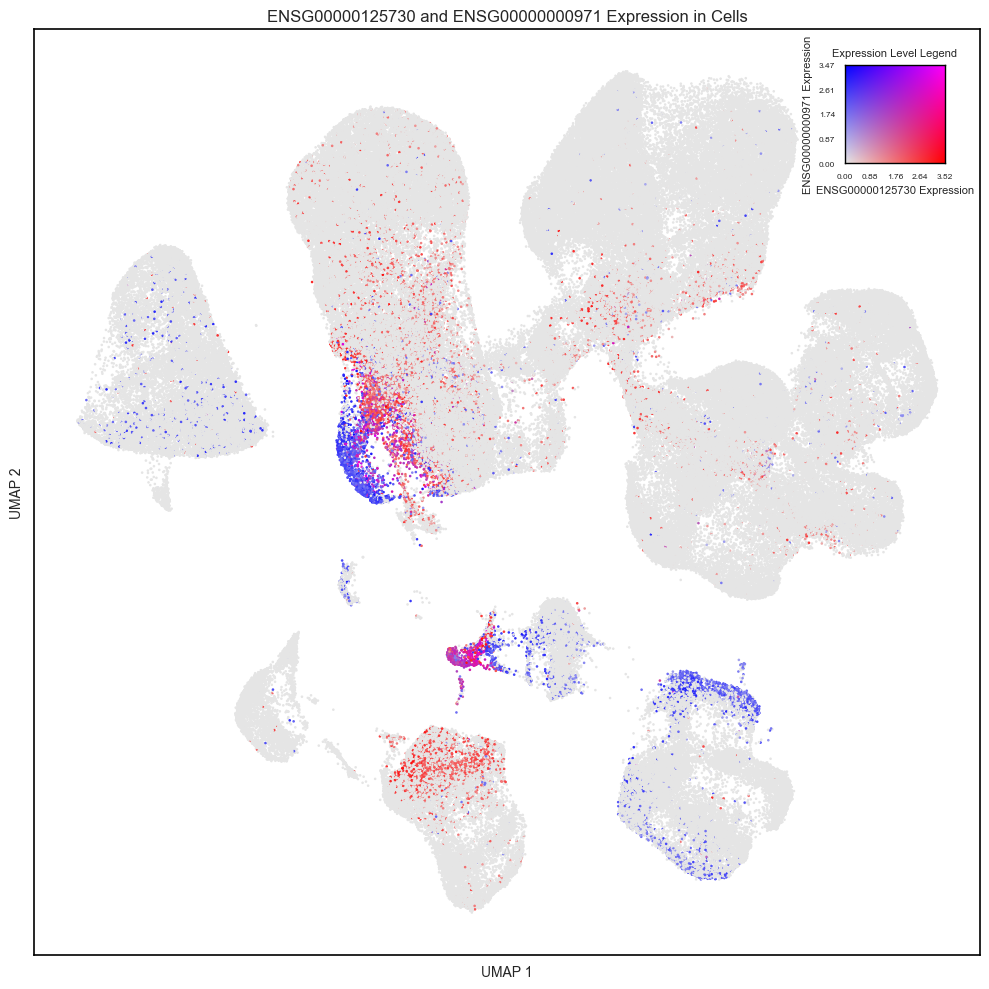

In [53]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

def plot_gene_expression_umap(adata, gene1, gene2):
    """
    Plots UMAP visualization of two gene expressions with a custom colormap.

    Parameters:
        adata (AnnData): The annotated data matrix.
        gene1 (str): First gene key (e.g., "ENSG00000125730").
        gene2 (str): Second gene key (e.g., "ENSG00000000971").
    """

    def get_expression(key):
        exp = adata[:, key].X
        return exp.toarray().flatten() if scipy.sparse.issparse(exp) else exp.flatten()

    # Extract expression data
    g1_vals = get_expression(gene1)
    g2_vals = get_expression(gene2)

    # Determine the data range for each gene
    g1_min, g1_max = g1_vals.min(), g1_vals.max()
    g2_min, g2_max = g2_vals.min(), g2_vals.max()

    # Generate five evenly spaced tick values
    g1_ticks = np.linspace(g1_min, g1_max, 5)
    g2_ticks = np.linspace(g2_min, g2_max, 5)

    # Rescale the raw data to [0,1] for color mapping
    X_scatter = (g1_vals - g1_min) / (g1_max - g1_min)
    Y_scatter = (g2_vals - g2_min) / (g2_max - g2_min)

    # Define the white basis as light grey
    white_val = 0.9

    # Compute weight factors
    w = (1 - X_scatter) * (1 - Y_scatter)
    r = X_scatter * (1 - Y_scatter)
    b = (1 - X_scatter) * Y_scatter
    p = X_scatter * Y_scatter

    # Compute scatter plot colors
    scatter_R = white_val * w + 1 * r + 0 * b + 1 * p
    scatter_G = white_val * w + 0 * r + 0 * b + 0 * p
    scatter_B = white_val * w + 0 * r + 1 * b + 1 * p

    scatter_colors = np.column_stack([scatter_R, scatter_G, scatter_B])
    scatter_colors = np.clip(scatter_colors, 0, 1)

    # Create figure and axes
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    ax_umap = fig.add_subplot(111)
    ax_legend = fig.add_axes([0.85, 0.83, 0.10, 0.10])
    ax_umap.set_facecolor('white')

    # Plot UMAP scatter
    ax_umap.scatter(
        adata.obsm['X_umap'][:, 0],
        adata.obsm['X_umap'][:, 1],
        c=scatter_colors,
        s=0.75,
        alpha=1.0
    )

    ax_umap.set_title(f'{gene1} and {gene2} Expression in Cells')
    ax_umap.set_xlabel('UMAP 1')
    ax_umap.set_ylabel('UMAP 2')
    ax_umap.grid(False)
    ax_umap.tick_params(axis='both', which='both', length=0)
    ax_umap.set_xticklabels([])
    ax_umap.set_yticklabels([])

    for spine in ax_umap.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.2)

    # ---- Build the legend colormap ----
    n_bins = 100
    x_lin = np.linspace(g1_min, g1_max, n_bins)
    y_lin = np.linspace(g2_min, g2_max, n_bins)
    X_leg, Y_leg = np.meshgrid(x_lin, y_lin)

    # Rescale legend meshgrid values to [0,1]
    X_leg_scaled = (X_leg - g1_min) / (g1_max - g1_min)
    Y_leg_scaled = (Y_leg - g2_min) / (g2_max - g2_min)

    # Compute weight factors for the legend
    w_leg = (1 - X_leg_scaled) * (1 - Y_leg_scaled)
    r_leg = X_leg_scaled * (1 - Y_leg_scaled)
    b_leg = (1 - X_leg_scaled) * Y_leg_scaled
    p_leg = X_leg_scaled * Y_leg_scaled

    # Compute legend color mapping
    legend_R = white_val * w_leg + 1 * r_leg + 0 * b_leg + 1 * p_leg
    legend_G = white_val * w_leg + 0 * r_leg + 0 * b_leg + 0 * p_leg
    legend_B = white_val * w_leg + 0 * r_leg + 1 * b_leg + 1 * p_leg

    legend_color = np.stack([legend_R, legend_G, legend_B], axis=2)
    legend_color = np.clip(legend_color, 0, 1)

    ax_legend.imshow(legend_color, origin='lower', extent=[g1_min, g1_max, g2_min, g2_max])
    ax_legend.set_xlabel(f'{gene1} Expression', fontsize=8)
    ax_legend.set_ylabel(f'{gene2} Expression', fontsize=8)
    ax_legend.set_title('Expression Level Legend', fontsize=8)
    ax_legend.grid(False)

    # Apply the new tick values
    ax_legend.set_xticks(g1_ticks)
    ax_legend.set_yticks(g2_ticks)
    ax_legend.set_xticklabels([f"{val:.2f}" for val in g1_ticks], fontsize=6)
    ax_legend.set_yticklabels([f"{val:.2f}" for val in g2_ticks], fontsize=6)

    for spine in ax_legend.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_gene_expression_umap(adata, "ENSG00000125730", "ENSG00000000971")

In [54]:
def plot_gene_expression(adata, gene1, gene2, gene_dict):
    """
    Plots UMAP visualization of two gene expressions with a custom colormap.

    Parameters:
        adata (AnnData): The annotated data matrix.
        gene1 (str): First gene key (e.g., "ENSG00000125730").
        gene2 (str): Second gene key (e.g., "ENSG00000000971").
        gene_dict (dict): A dictionary mapping Ensembl gene IDs to gene names.
    """

    def get_expression(key):
        exp = adata[:, key].X
        return exp.toarray().flatten() if scipy.sparse.issparse(exp) else exp.flatten()

    # Extract expression data
    g1_vals = get_expression(gene1)
    g2_vals = get_expression(gene2)

    # Determine the data range for each gene
    g1_min, g1_max = g1_vals.min(), g1_vals.max()
    g2_min, g2_max = g2_vals.min(), g2_vals.max()

    # Generate five evenly spaced tick values
    g1_ticks = np.linspace(g1_min, g1_max, 5)
    g2_ticks = np.linspace(g2_min, g2_max, 5)

    # Rescale the raw data to [0,1] for color mapping
    X_scatter = (g1_vals - g1_min) / (g1_max - g1_min)
    Y_scatter = (g2_vals - g2_min) / (g2_max - g2_min)

    # Define the white basis as light grey
    white_val = 0.9

    # Compute weight factors
    w = (1 - X_scatter) * (1 - Y_scatter)
    r = X_scatter * (1 - Y_scatter)
    b = (1 - X_scatter) * Y_scatter
    p = X_scatter * Y_scatter

    # Compute scatter plot colors
    scatter_R = white_val * w + 1 * r + 0 * b + 1 * p
    scatter_G = white_val * w + 0 * r + 0 * b + 0 * p
    scatter_B = white_val * w + 0 * r + 1 * b + 1 * p

    scatter_colors = np.column_stack([scatter_R, scatter_G, scatter_B])
    scatter_colors = np.clip(scatter_colors, 0, 1)

    # Create figure and axes
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    ax_umap = fig.add_subplot(111)
    ax_legend = fig.add_axes([0.85, 0.83, 0.10, 0.10])
    ax_umap.set_facecolor('white')

    # Plot UMAP scatter
    ax_umap.scatter(
        adata.obsm['X_umap'][:, 0],
        adata.obsm['X_umap'][:, 1],
        c=scatter_colors,
        s=0.75,
        alpha=1.0
    )

    # Get gene names from the gene_dict
    gene1_name = gene_dict.get(gene1, gene1)  # Use gene ID if name is not found
    gene2_name = gene_dict.get(gene2, gene2)  # Use gene ID if name is not found

    # Update plot title and labels
    ax_umap.set_title(f'{gene1_name} and {gene2_name} Expression in Cells')
    ax_umap.set_xlabel('UMAP 1')
    ax_umap.set_ylabel('UMAP 2')
    ax_umap.grid(False)
    ax_umap.tick_params(axis='both', which='both', length=0)
    ax_umap.set_xticklabels([])
    ax_umap.set_yticklabels([])

    for spine in ax_umap.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.2)

    # ---- Build the legend colormap ----
    n_bins = 100
    x_lin = np.linspace(g1_min, g1_max, n_bins)
    y_lin = np.linspace(g2_min, g2_max, n_bins)
    X_leg, Y_leg = np.meshgrid(x_lin, y_lin)

    # Rescale legend meshgrid values to [0,1]
    X_leg_scaled = (X_leg - g1_min) / (g1_max - g1_min)
    Y_leg_scaled = (Y_leg - g2_min) / (g2_max - g2_min)

    # Compute weight factors for the legend
    w_leg = (1 - X_leg_scaled) * (1 - Y_leg_scaled)
    r_leg = X_leg_scaled * (1 - Y_leg_scaled)
    b_leg = (1 - X_leg_scaled) * Y_leg_scaled
    p_leg = X_leg_scaled * Y_leg_scaled

    # Compute legend color mapping
    legend_R = white_val * w_leg + 1 * r_leg + 0 * b_leg + 1 * p_leg
    legend_G = white_val * w_leg + 0 * r_leg + 0 * b_leg + 0 * p_leg
    legend_B = white_val * w_leg + 0 * r_leg + 1 * b_leg + 1 * p_leg

    legend_color = np.stack([legend_R, legend_G, legend_B], axis=2)
    legend_color = np.clip(legend_color, 0, 1)

    ax_legend.imshow(legend_color, origin='lower', extent=[g1_min, g1_max, g2_min, g2_max])
    ax_legend.set_xlabel(f'{gene1_name} Expression', fontsize=8)
    ax_legend.set_ylabel(f'{gene2_name} Expression', fontsize=8)
    ax_legend.set_title('Expression Level Legend', fontsize=8)
    ax_legend.grid(False)

    # Apply the new tick values
    ax_legend.set_xticks(g1_ticks)
    ax_legend.set_yticks(g2_ticks)
    ax_legend.set_xticklabels([f"{val:.2f}" for val in g1_ticks], fontsize=6)
    ax_legend.set_yticklabels([f"{val:.2f}" for val in g2_ticks], fontsize=6)

    for spine in ax_legend.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

# Example usage:
# gene_dict = {"ENSG00000125730": "C3", "ENSG00000000971": "CFH"}  # Example dictionary
# plot_gene_expression(adata, "ENSG00000125730", "ENSG00000000971", gene_dict)


/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_4602/1864835801.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


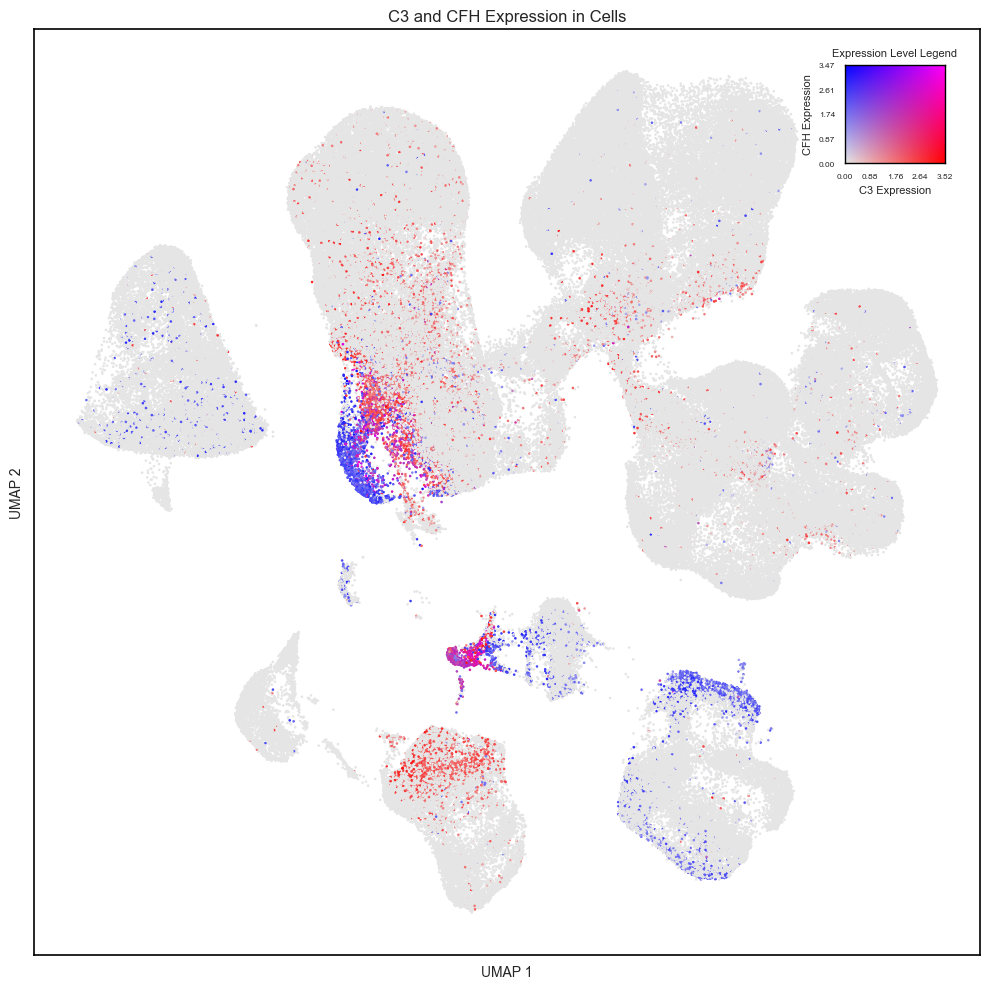

In [55]:
gene_dict = {
    "ENSG00000125730": "C3",
    "ENSG00000000971": "CFH"
}
plot_gene_expression(adata, "ENSG00000125730", "ENSG00000000971", gene_dict)
